In [ ]:
import pandas as pd
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import TensorDataset
!pip install FedTools
from FedTools import FederalReserveMins
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from scipy.special import softmax
import string

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 2.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
# Load FinBERT model
model_name = "ProsusAI/finbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
dataset = FederalReserveMins(start_year=2003, historical_split = 2017).find_minutes()

Constructing links between 2003 and 2023
Extracting Federal Reserve Minutes.
Retrieving articles.
.....................................................................................................................................................................

In [ ]:
dataset

In [ ]:
date_list = dataset.index.strftime('%Y-%m-%d').tolist()

print(date_list)

['2003-01-29', '2003-03-18', '2003-05-06', '2003-06-25', '2003-08-12', '2003-09-16', '2003-10-28', '2003-12-09', '2004-01-28', '2004-03-16', '2004-05-04', '2004-06-30', '2004-08-10', '2004-09-21', '2004-11-10', '2004-12-14', '2005-02-02', '2005-03-22', '2005-05-03', '2005-06-30', '2005-08-09', '2005-09-20', '2005-11-01', '2005-12-13', '2006-01-31', '2006-03-28', '2006-05-10', '2006-06-29', '2006-08-08', '2006-09-20', '2006-10-25', '2006-12-12', '2007-01-31', '2007-03-21', '2007-05-09', '2007-06-28', '2007-08-07', '2007-09-18', '2007-10-31', '2007-12-11', '2008-01-30', '2008-03-18', '2008-04-30', '2008-08-05', '2008-09-16', '2008-10-29', '2008-12-16', '2009-01-28', '2009-03-18', '2009-04-29', '2009-06-24', '2009-08-12', '2009-09-23', '2009-11-04', '2009-12-16', '2010-01-27', '2010-03-16', '2010-04-28', '2010-06-23', '2010-08-10', '2010-09-21', '2010-11-03', '2010-12-14', '2011-01-26', '2011-03-15', '2011-04-27', '2011-06-22', '2011-08-09', '2011-09-21', '2011-11-02', '2011-12-13', '2012

In [ ]:
def extract_long_paragraphs(content):
    # Clean the text
    content = content.replace('\n', ' ').replace('\xa0', ' ')

    # Find the length of paragraphs and extract paragraphs that are only greater than 200 characters
    long_paragraphs = []
    for paragraph in content.split('.'):
        if len(paragraph) > 200:
            long_paragraphs.append(paragraph.strip())

    return long_paragraphs

# Apply the extract_long_paragraphs function to each row in the dataframe
long_paragraphs_list = []
for index, row in dataset.iterrows():
    long_paragraphs = extract_long_paragraphs(row['Federal_Reserve_Mins'])
    long_paragraphs_list.append(long_paragraphs)
len(long_paragraphs_list)

161

In [ ]:
# Define a function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join the words back into a single string
    text = ' '.join(words)

    return text

# Define a function to get the sentiment score for each paragraph
def get_sentiment(paragraph):
    preprocessed_paragraph = preprocess_text(paragraph)
    inputs = tokenizer(preprocessed_paragraph, return_tensors='pt')
    outputs = model(**inputs)
    logits = outputs.logits.detach().numpy()[0]
    probabilities = softmax(logits)
    sentiment_score = probabilities[1]
    return sentiment_score

In [ ]:
import pickle

In [ ]:
# Create a list to store the sentiment scores
sentiment_scores = []
dates = []

# Iterate over the long paragraphs in the long_paragraph_list and get the sentiment score for each one
for i, row in enumerate(long_paragraphs_list):
    for paragraph in row:
        sentiment_score = get_sentiment(paragraph)
        sentiment_scores.append(sentiment_score)
        dates.append(date_list[i])

# Create a dataframe with the sentiment scores
df_sentiment = pd.DataFrame({'paragraph': [paragraph for row in long_paragraphs_list for paragraph in row],
                             'sentiment_score': sentiment_scores,
                             'date': dates})

# Store data (serialize)
with open('sentimentScores.pickle', 'wb') as handle:
    pickle.dump(sentiment_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('sentimentDF.pickle', 'wb') as handle:
    pickle.dump(df_sentiment, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Running the below code using a pickle file to save time after running the model

In [ ]:
import pickle

In [ ]:
# Load the serialized data from the minutesAll.pickle file
with open('sentimentScores.pickle', 'rb') as handle:
    sentiment_scores = pickle.load(handle)

# Load the serialized data from the wordcloudAll.pickle file
with open('sentimentDF.pickle', 'rb') as handle:
    df_sentiment = pickle.load(handle)

In [ ]:
len(sentiment_scores)

26968

In [ ]:
df_sentiment

,paragraph,sentiment_score,date
0,"Miller and Rudebusch, Vice Presidents, Federal...",0.107282,2003-01-29
1,"Hoenig, President of the Federal Reserve Bank ...",0.119337,2003-01-29
2,Wilcox Associate Economists By unanimo...,0.044176,2003-01-29
3,"By unanimous vote, Dino Kos was selected to se...",0.017983,2003-01-29
4,"5 By unanimous vote, the Committee approved ...",0.018140,2003-01-29
...,...,...,...
26963,In determining the extent of future increases ...,0.114308,2023-03-22
26964,The Committee's assessments will take into acc...,0.036267,2023-03-22
26965,To support the Committee's decision to raise t...,0.022130,2023-03-22
26966,"In taking this action, the Board approved requ...",0.050176,2023-03-22


In [ ]:
positive_sentences = df_sentiment[df_sentiment['sentiment_score'] >= 0.5]['paragraph'].tolist()
negative_sentences = df_sentiment[df_sentiment['sentiment_score'] < 0.5]['paragraph'].tolist()
# Step 6: Print the results
print('Positive Sentences:')
print(len(positive_sentences))
print('Negative Sentences:')
print(len(negative_sentences))

Positive Sentences:
8026
Negative Sentences:
18942


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

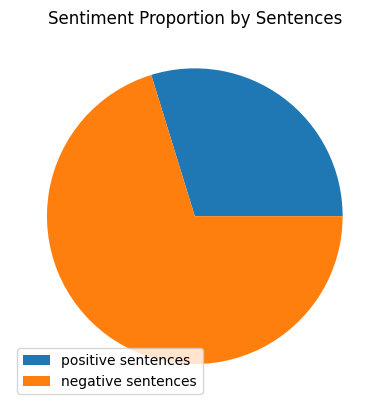

In [ ]:
plt.pie([len(positive_sentences),len(negative_sentences) ])
plt.legend(['positive sentences', 'negative sentences'])
plt.title('Sentiment Proportion by Sentences')
plt.show()

In [ ]:
import pandas as pd
ff = pd.read_csv("DFF.csv")

In [ ]:
ff

,DATE,DFF
0,2003-01-01,1.16
1,2003-01-02,1.30
2,2003-01-03,1.12
3,2003-01-04,1.12
4,2003-01-05,1.12
...,...,...
7424,2023-04-30,4.83
7425,2023-05-01,4.83
7426,2023-05-02,4.83
7427,2023-05-03,4.83


In [ ]:
dfs = df_sentiment.copy()

In [ ]:
dfs

,paragraph,sentiment_score,date
0,"Miller and Rudebusch, Vice Presidents, Federal...",0.107282,2003-01-29
1,"Hoenig, President of the Federal Reserve Bank ...",0.119337,2003-01-29
2,Wilcox Associate Economists By unanimo...,0.044176,2003-01-29
3,"By unanimous vote, Dino Kos was selected to se...",0.017983,2003-01-29
4,"5 By unanimous vote, the Committee approved ...",0.018140,2003-01-29
...,...,...,...
26963,In determining the extent of future increases ...,0.114308,2023-03-22
26964,The Committee's assessments will take into acc...,0.036267,2023-03-22
26965,To support the Committee's decision to raise t...,0.022130,2023-03-22
26966,"In taking this action, the Board approved requ...",0.050176,2023-03-22


In [ ]:
# convert the date column to datetime format
dfs['date'] = pd.to_datetime(dfs['date'])

# group the data by date and sum the sentiment scores
grouped_dfs = dfs.groupby('date', as_index=False)['sentiment_score'].mean()

grouped_dfs

,date,sentiment_score
0,2003-01-29,0.291500
1,2003-03-18,0.357522
2,2003-05-06,0.281242
3,2003-06-25,0.278055
4,2003-08-12,0.224150
...,...,...
156,2022-09-21,0.307588
157,2022-11-02,0.308614
158,2022-12-14,0.373795
159,2023-02-01,0.347764


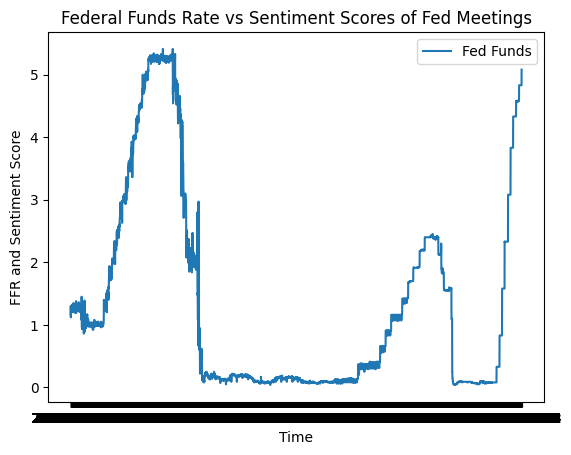

In [ ]:
import matplotlib.pyplot as plt
# plot the two lines on the same plot
plt.plot(ff['DATE'], ff['DFF'], label='Fed Funds')
#plt.plot(grouped_dfs['date'], grouped_dfs['sentiment_score'], label='Sentiment Scores')

# set the plot title and axes labels
plt.title('Federal Funds Rate vs Sentiment Scores of Fed Meetings')
plt.xlabel('Time')
plt.ylabel('FFR and Sentiment Score')

# show the legend
plt.legend()

# show the plot
plt.show()

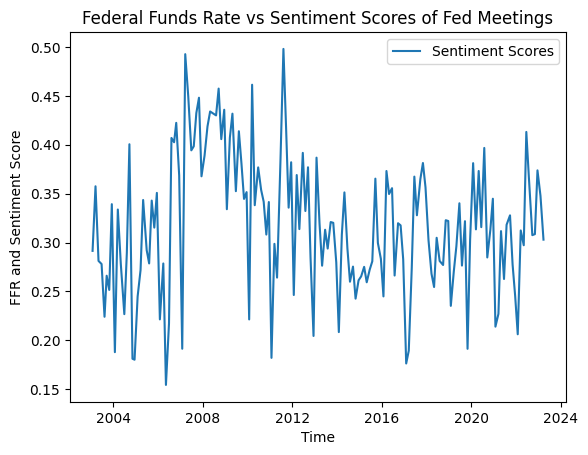

In [ ]:
plt.plot(grouped_dfs['date'], grouped_dfs['sentiment_score'], label='Sentiment Scores')

# set the plot title and axes labels
plt.title('Federal Funds Rate vs Sentiment Scores of Fed Meetings')
plt.xlabel('Time')
plt.ylabel('FFR and Sentiment Score')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
ff=ff.rename(columns={"DATE": "date"})
grouped_dfs['date'] = pd.to_datetime(grouped_dfs['date']) #fixing datetime errors
ff['date'] = pd.to_datetime(ff['date'])
merged_df = pd.merge(ff, grouped_dfs, on='date', how='left')#create a dataframe with the federal fund rates and duplicated
merged_df['sentiment_score'].fillna(method='ffill', inplace=True)
merged_df['sentiment_score'].fillna(0.291500, inplace=True)
merged_df['date']= merged_df['date'].dt.strftime('%Y-%m-%d')
data_dict=merged_df.to_dict(orient='records')

In [ ]:
data_dict

[{'date': '2003-01-01', 'DFF': 1.16, 'sentiment_score': 0.2915},
 {'date': '2003-01-02', 'DFF': 1.3, 'sentiment_score': 0.2915},
 {'date': '2003-01-03', 'DFF': 1.12, 'sentiment_score': 0.2915},
 {'date': '2003-01-04', 'DFF': 1.12, 'sentiment_score': 0.2915},
 {'date': '2003-01-05', 'DFF': 1.12, 'sentiment_score': 0.2915},
 {'date': '2003-01-06', 'DFF': 1.22, 'sentiment_score': 0.2915},
 {'date': '2003-01-07', 'DFF': 1.2, 'sentiment_score': 0.2915},
 {'date': '2003-01-08', 'DFF': 1.29, 'sentiment_score': 0.2915},
 {'date': '2003-01-09', 'DFF': 1.29, 'sentiment_score': 0.2915},
 {'date': '2003-01-10', 'DFF': 1.25, 'sentiment_score': 0.2915},
 {'date': '2003-01-11', 'DFF': 1.25, 'sentiment_score': 0.2915},
 {'date': '2003-01-12', 'DFF': 1.25, 'sentiment_score': 0.2915},
 {'date': '2003-01-13', 'DFF': 1.26, 'sentiment_score': 0.2915},
 {'date': '2003-01-14', 'DFF': 1.24, 'sentiment_score': 0.2915},
 {'date': '2003-01-15', 'DFF': 1.3, 'sentiment_score': 0.2915},
 {'date': '2003-01-16', 'DFF

In [ ]:
!pip install notebookjs
from notebookjs import execute_js

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00


In [ ]:
#loading JS and CSS files for D3 visualization
code_js  = open("/content/drive/MyDrive/Colab Notebooks/HW2 vizualisation/vis02.js", "r").read()
code_css = open("/content/drive/MyDrive/Colab Notebooks/HW2 vizualisation/vis01.css", "r").read()

In [ ]:
code_js  = open("/content/drive/MyDrive/Colab Notebooks/vis02.js", "r").read()
code_css = open("/content/drive/MyDrive/Colab Notebooks/vis01.css", "r").read()

In [ ]:
#same visualization in D3
d3_path = "https://d3js.org/d3.v7.min.js"

execute_js(library_list=[d3_path, code_js], 
           main_function="draw_scatter_plot_color", 
           css_list=[code_css],
           data_dict=data_dict)

In [ ]:
#same visualization in D3
d3_path = "https://d3js.org/d3.v7.min.js"

execute_js(library_list=[d3_path, code_js], 
           main_function="draw_scatter_plot_color2", 
           css_list=[code_css],
           data_dict=data_dict)